In [193]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import sklearn
from sklearn import datasets

In [194]:
from google.colab import files
uploaded = files.upload()

Saving german_credit_data.csv to german_credit_data (1).csv


In [330]:
data_init = pd.read_csv('german_credit_data.csv', sep=',').drop("Unnamed: 0",axis = 1)
data_init.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [331]:
numerical =["Age","Credit amount", "Duration"]
categorical = ['Sex','Job','Housing','Saving accounts','Checking account','Purpose']

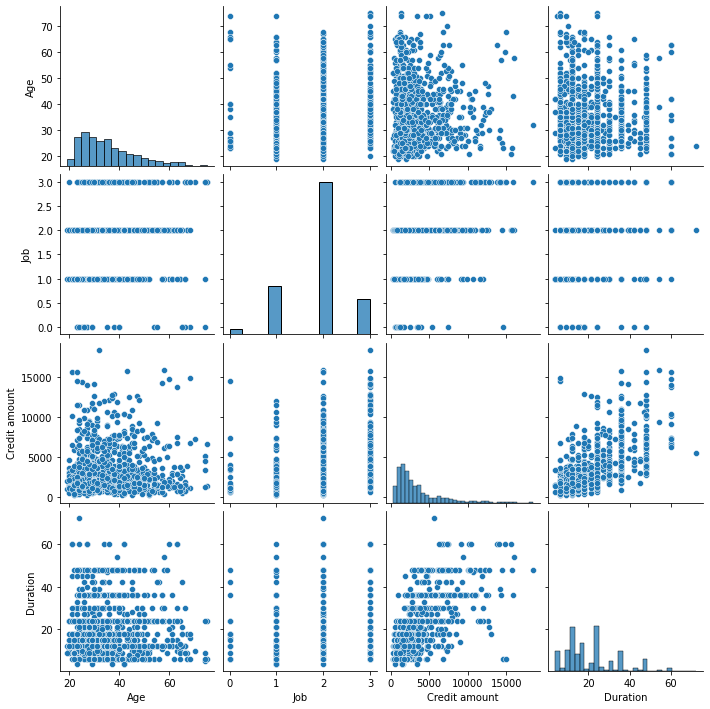

In [332]:
sns.pairplot(data_init)

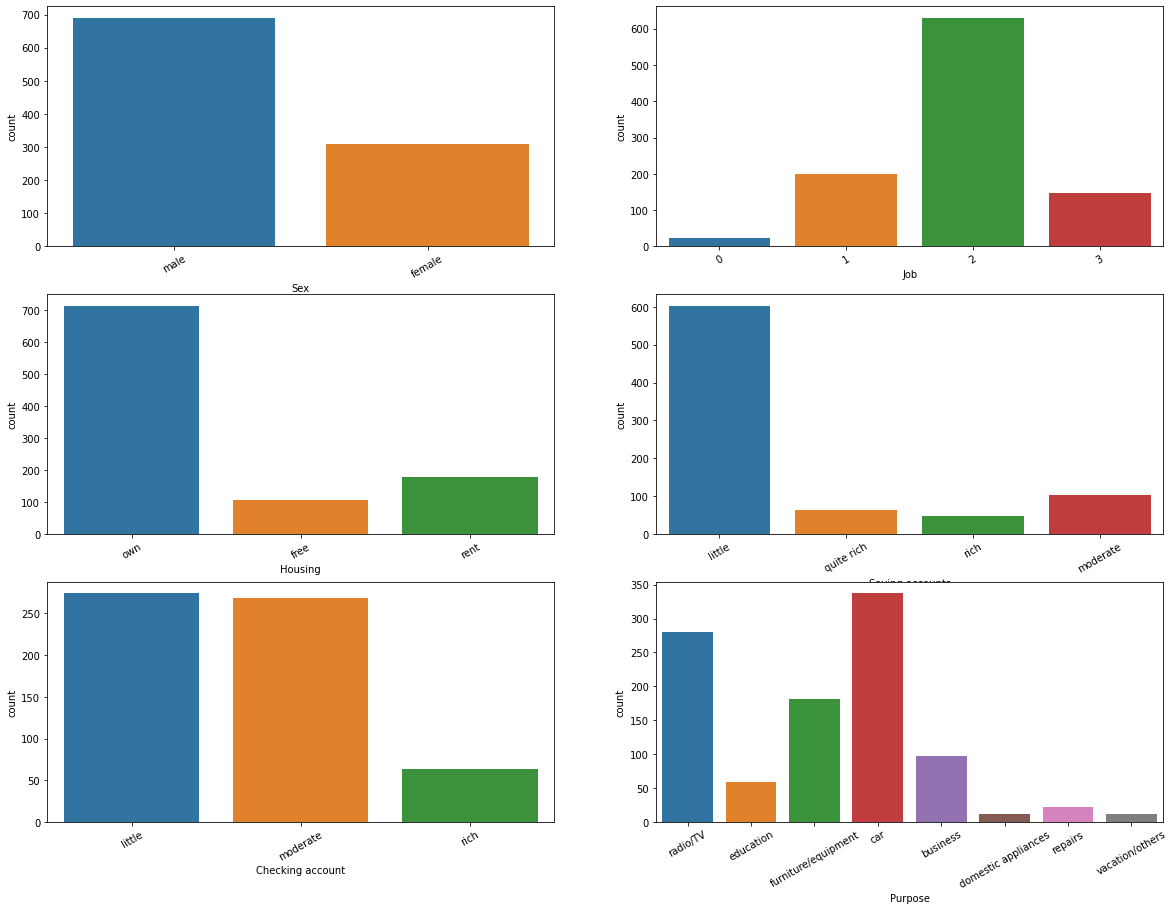

In [333]:
fig = plt.figure(figsize = (20,15))
axes = 320
for cat in categorical:
    axes += 1
    fig.add_subplot(axes)
    sns.countplot(data = data_init, x = cat)
    plt.xticks(rotation=30)
plt.show()

In [334]:
def missing_values_vizu(df):
    missing_by_col=df.isnull().sum()
    col_with_na=missing_by_col[missing_by_col>0]
    percent_missing=(col_with_na/len(df))*100
    percent_missing=percent_missing.sort_values(ascending=False)
    
    plt.figure(1, figsize=(15, 12))
    sns.barplot(x=percent_missing.index,y=percent_missing)

    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)

def imputeNA(df):
    #columns with missigns values
    cols_with_missings=[col for col in df.columns if df[col].isnull().any()]
    #numericals and categorials columns with missings values
    cols_num_with_missings=[col for col in df.loc[:,cols_with_missings].columns
                        if df[col].dtypes=='float64' or df[col].dtypes=='int64']
    cols_cat_with_missings=[col for col in df.loc[:,cols_with_missings].columns
                        if df[col].dtypes=='object']
    
    cat_subset=df.loc[:,cols_cat_with_missings]
    num_subset=df.loc[:,cols_num_with_missings]
    
    #mode imputation for categorial columns
    for cat_col in cat_subset.columns:
        df[cat_col].fillna(df[cat_col].mode()[0],inplace=True)
        
    #mean imputaion in the numerical columns
    for col in num_subset.columns:
        df[col].fillna(df[col].mean(),inplace=True)
        
    return df
  



In [335]:
#missing_values_vizu(df)
data = data_init.copy()
data = imputeNA(data)
#data.isna().sum().sum()
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,little,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,little,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [336]:
data["Saving accounts"].replace(to_replace = {"little":1,"moderate":2,"quite rich":3,"rich":4}, inplace = True)

data["Checking account"].replace(to_replace = {"little":1,"moderate":2,"rich":3}, inplace = True)
data["Sex"].replace(to_replace = {"female": 0, "male":1}, inplace = True)
data["Housing"].replace(to_replace = {"free": 0, "rent":1,"own":3}, inplace = True)


In [337]:
from sklearn.preprocessing import LabelEncoder

encod = LabelEncoder()
data.Purpose = encod.fit_transform(data.Purpose)


data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,3,1,1,1169,6,5
1,22,0,2,3,1,2,5951,48,5
2,49,1,1,3,1,1,2096,12,3
3,45,1,2,0,1,1,7882,42,4
4,53,1,2,0,1,1,4870,24,1


# KMeans

In [338]:
from sklearn.cluster import KMeans

def plot_cluster(data,y_pred,centers):
  n_features = data.shape[1]
  for i in range(0,n_features):
    for j in range(0,n_features):
      sns.scatterplot(x=data.iloc[:, i], y=data.iloc[:, j], hue=y_pred, palette='cool', style=y_pred) 
      sns.scatterplot(x=centers[:, i], y=centers[:, j])
      plt.show()


In [339]:
def nb_cluster(data):
  sse = {}
  for k in range(1, 10):
      kmeans = KMeans(n_clusters=k, max_iter=1000, init='k-means++').fit(data)
      #data["clusters"] = kmeans.labels_
      #print(data["clusters"])
      sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
  plt.figure()
  plt.plot(list(sse.keys()), list(sse.values()))
  plt.xlabel("Number of cluster")
  plt.ylabel("SSE")
  plt.show()

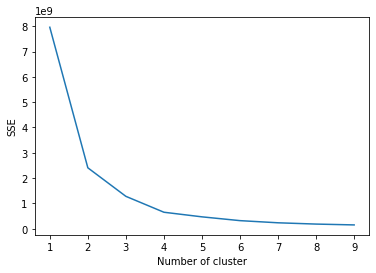

In [340]:
nb_cluster(data)

Le nombre idéal de clustrer est de 2,3 ou 4 cluster 

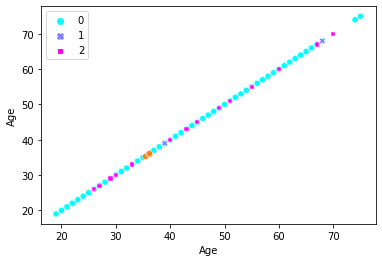

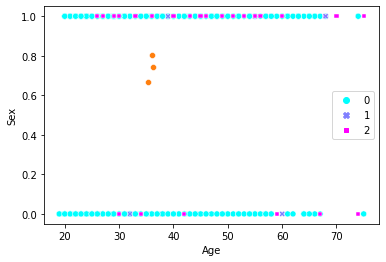

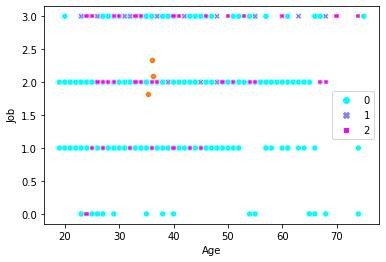

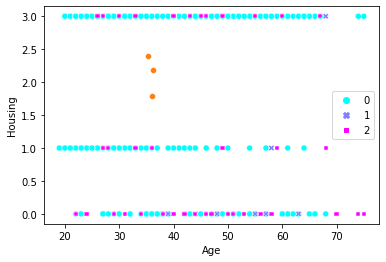

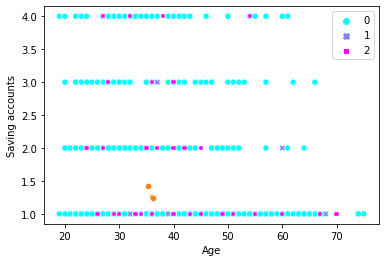

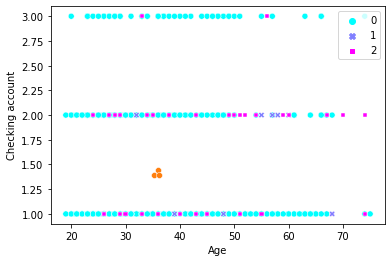

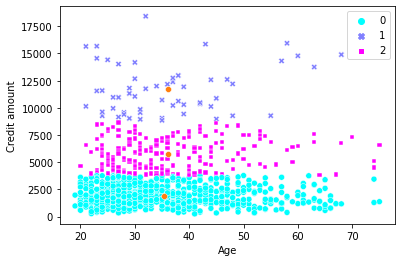

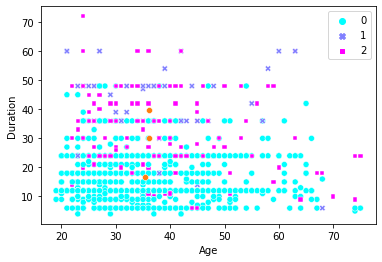

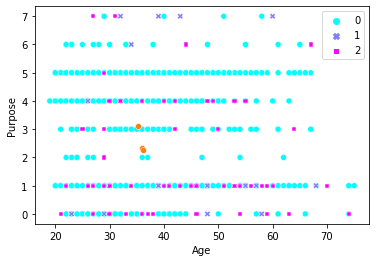

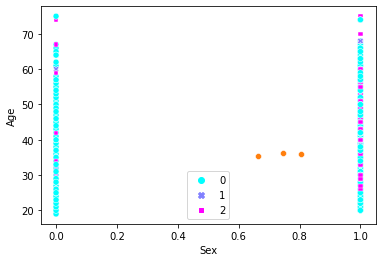

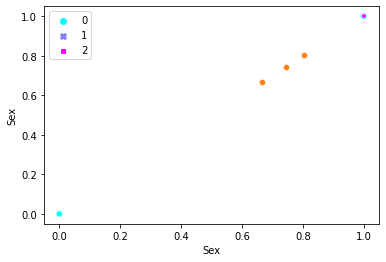

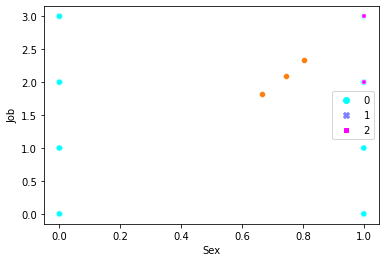

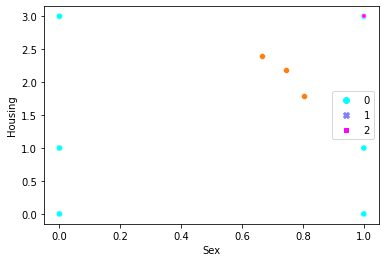

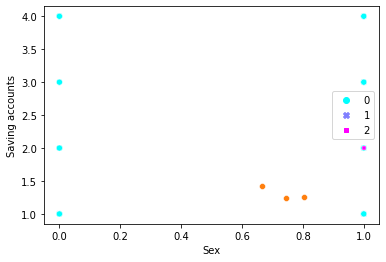

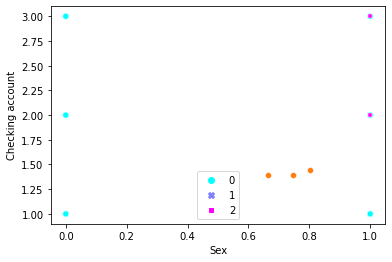

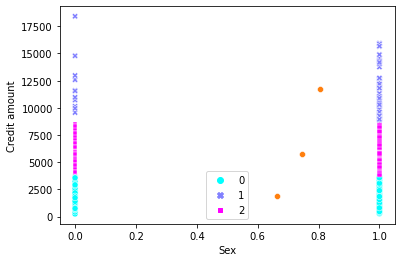

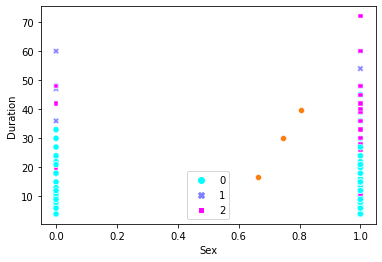

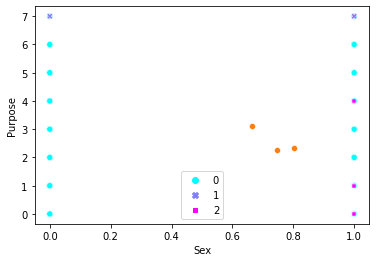

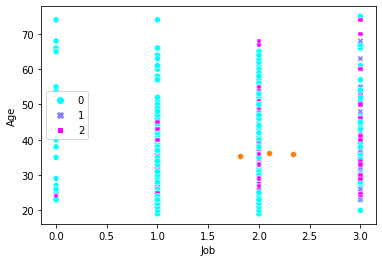

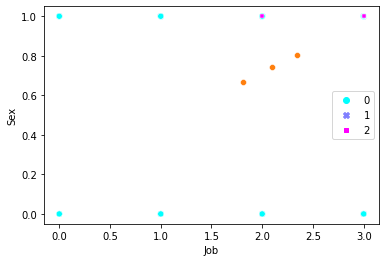

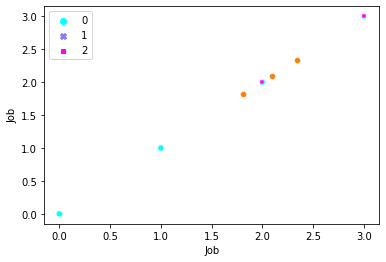

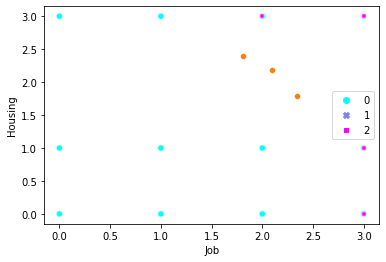

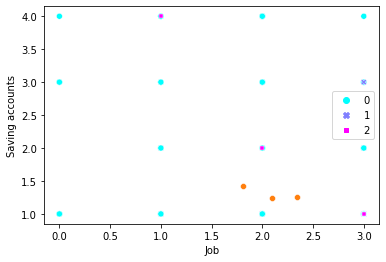

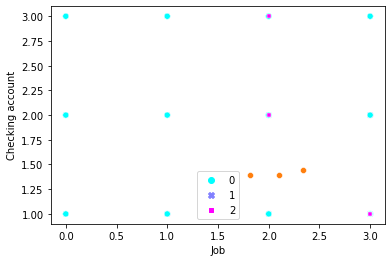

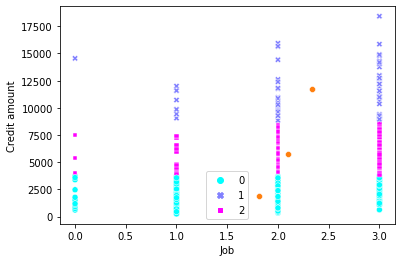

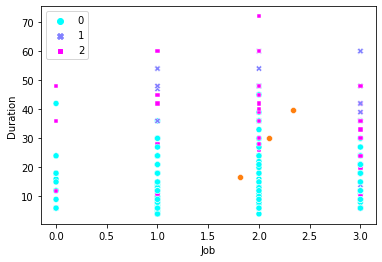

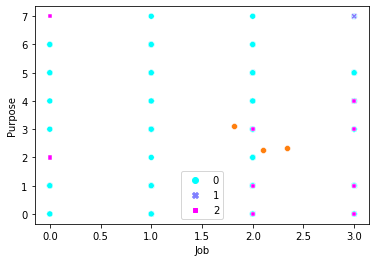

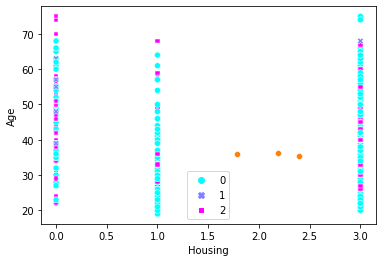

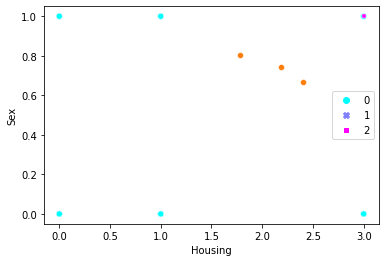

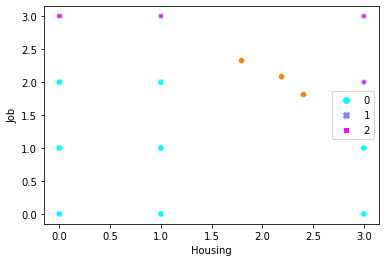

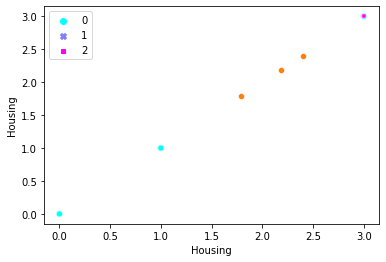

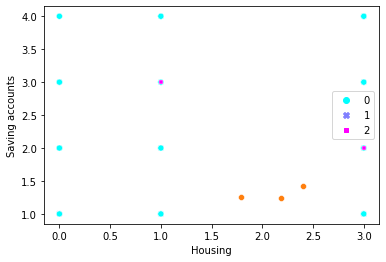

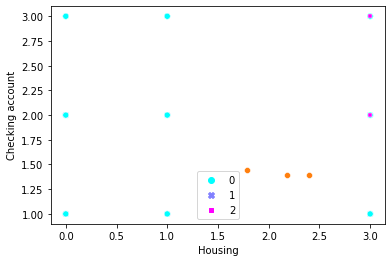

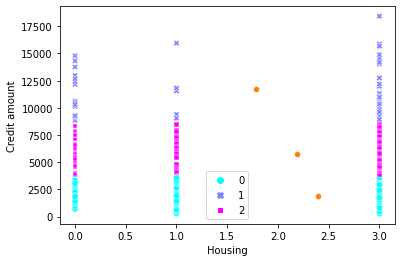

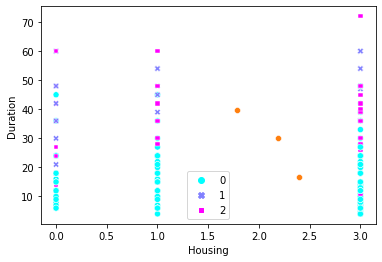

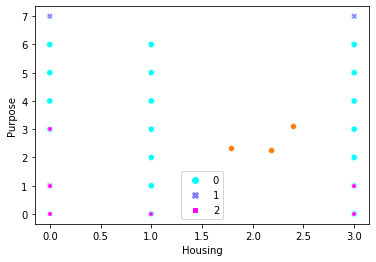

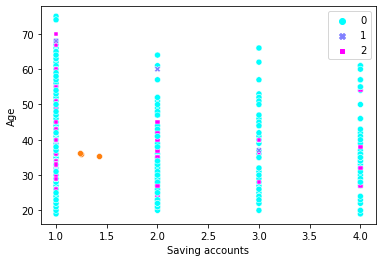

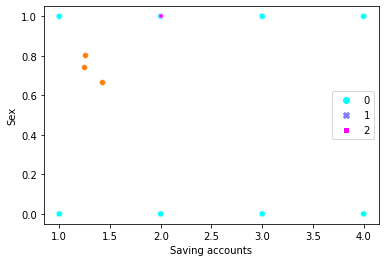

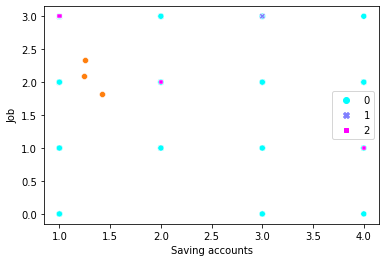

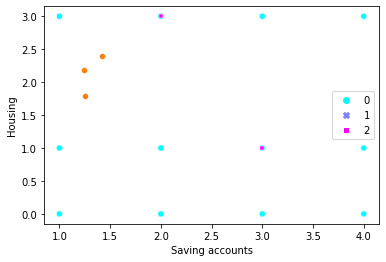

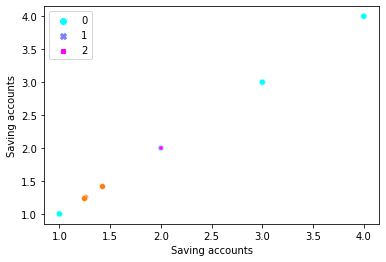

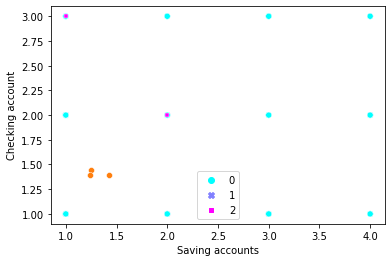

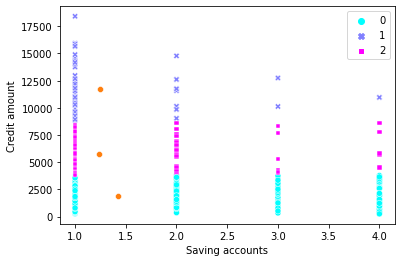

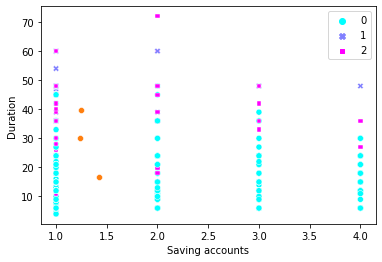

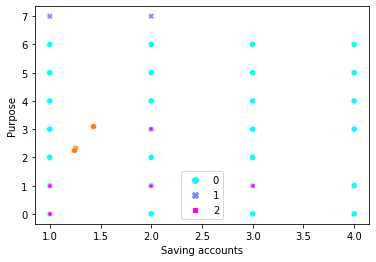

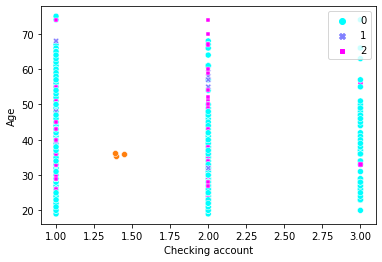

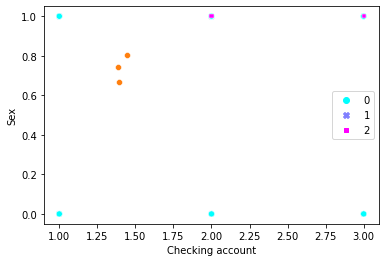

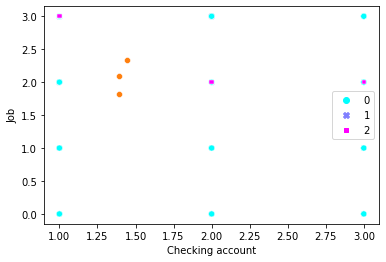

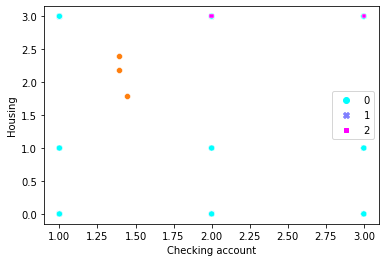

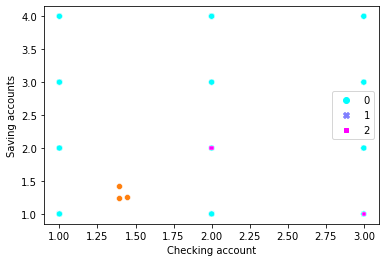

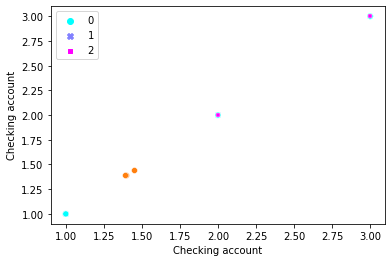

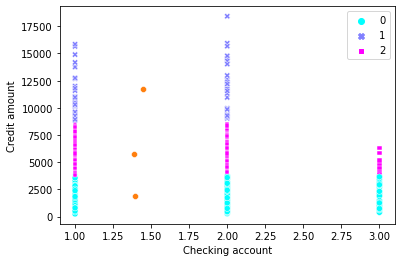

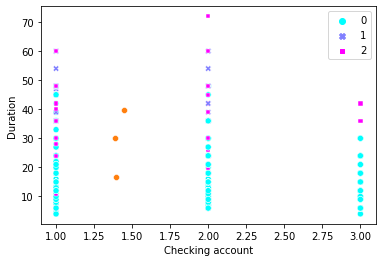

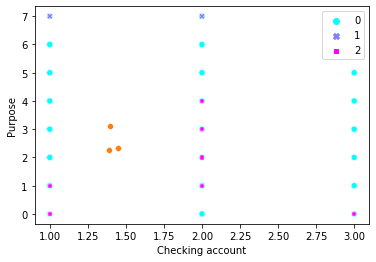

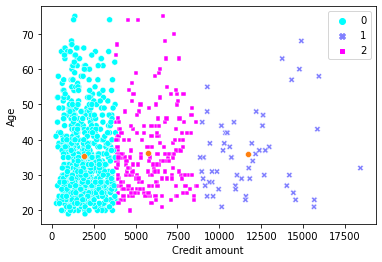

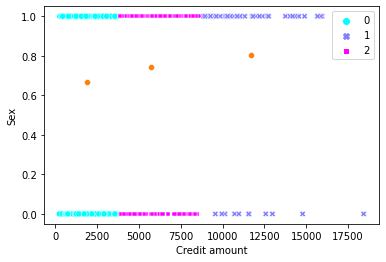

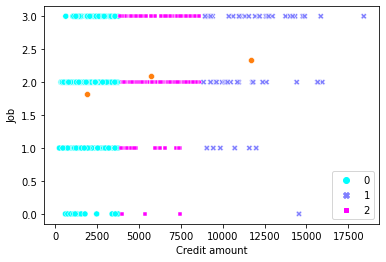

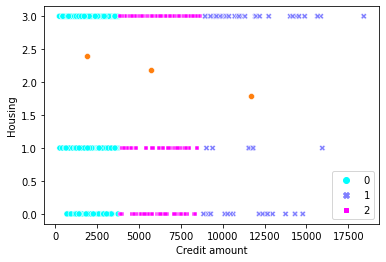

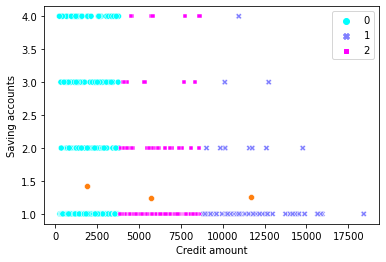

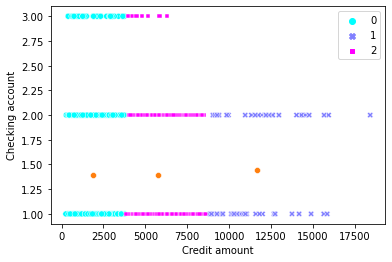

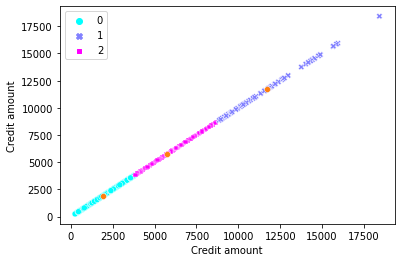

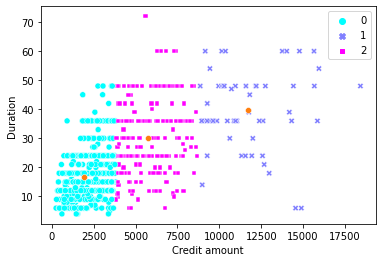

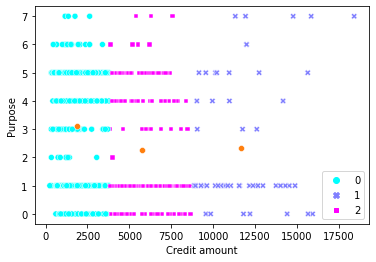

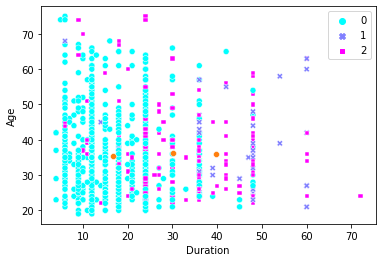

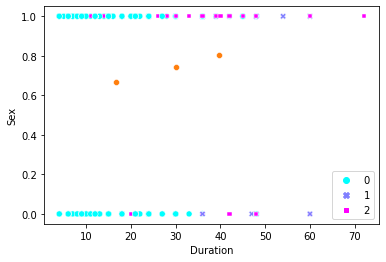

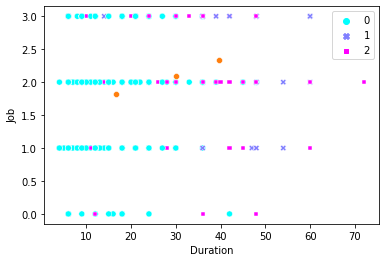

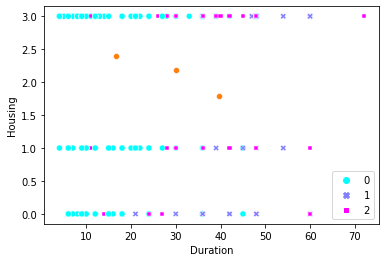

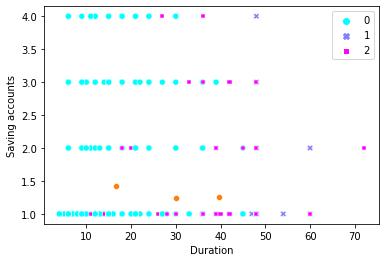

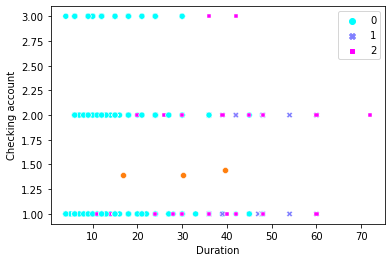

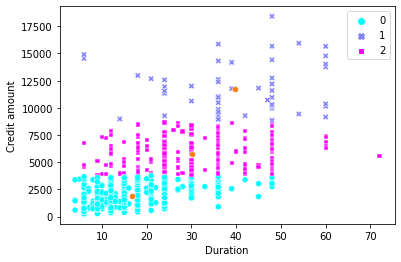

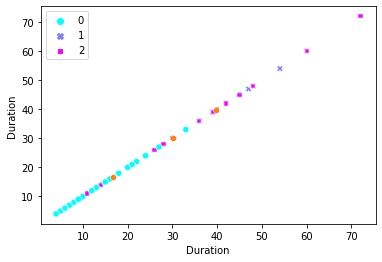

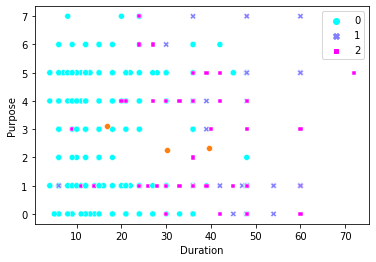

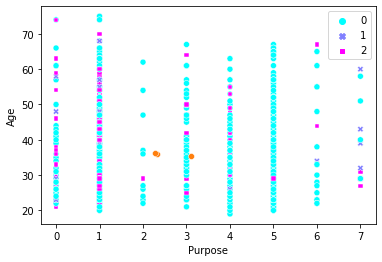

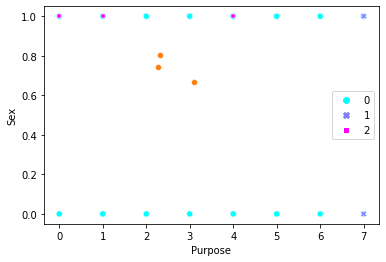

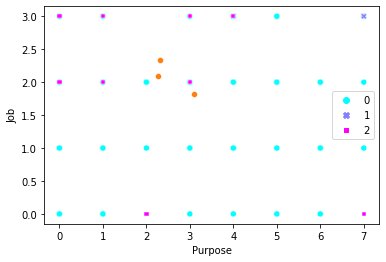

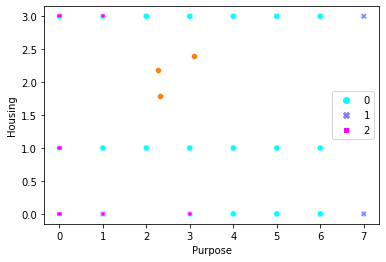

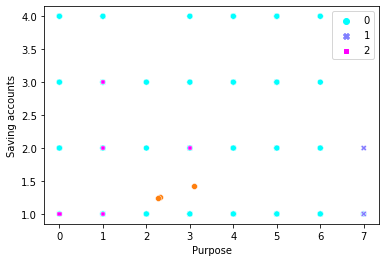

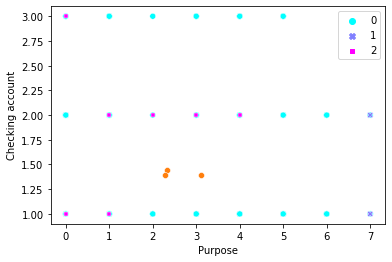

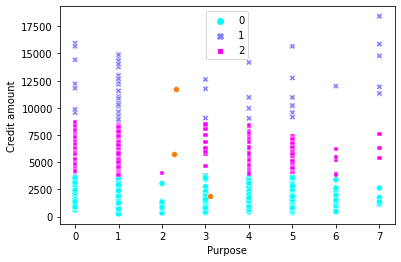

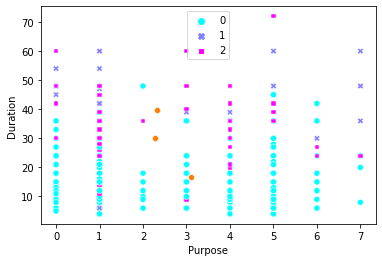

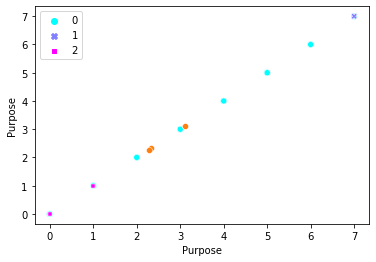

In [341]:
kmeans = KMeans(n_clusters=3).fit(data)

y_pred = kmeans.predict(data)
C = kmeans.cluster_centers_


plot_cluster(data,y_pred,C)


In [342]:
def tab(data,ypred): 
  df_y_pred = pd.DataFrame(data=y_pred, columns=['cluster'])
  tab1 = pd.concat([data, df_y_pred], axis=1)
  display(tab1.groupby(['cluster'])["Age","Credit amount", "Duration"].agg(['mean', 'median']).reset_index())
  display(tab1.groupby(["cluster"])[[i for i in categorical]].apply(lambda x: x.mode()))

tab(data,y_pred)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


cluster        Age        Credit amount            Duration       
                mean median          mean   median       mean median
0       0  35.318681   33.0   1890.082418   1745.0  16.718407   15.0
1       1  36.053571   34.5  11695.589286  11191.0  39.660714   36.0
2       2  36.180556   34.0   5742.245370   5726.5  30.143519   27.5

,,Sex,Job,Housing,Saving accounts,Checking account,Purpose
cluster,,,,,,,
0,0,1,2,3,1,1,5
1,0,1,3,3,1,1,1
2,0,1,2,3,1,1,1


In [343]:
data_init.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


**les variables categoriels ont des modes proches, elles n'influes que peu sur les cluster. c'est surtout "Credit Amount" qui a des stats trés différentes par cluster(a regarder pour standardiser la variable).**

In [344]:
from sklearn.preprocessing import StandardScaler
data_scaler = data.copy()

scaler = StandardScaler()
data_scaler[numerical] = scaler.fit_transform(data_scaler[numerical])

data_scaler.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,2.766456,1,2,3,1,1,-0.745131,-1.236478,5
1,-1.191404,0,2,3,1,2,0.949817,2.248194,5
2,1.183312,1,1,3,1,1,-0.416562,-0.738668,3
3,0.831502,1,2,0,1,1,1.634247,1.750384,4
4,1.535122,1,2,0,1,1,0.566664,0.256953,1


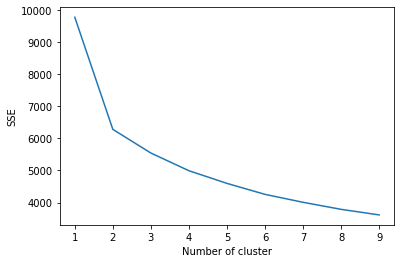

In [345]:
nb_cluster(data_scaler)

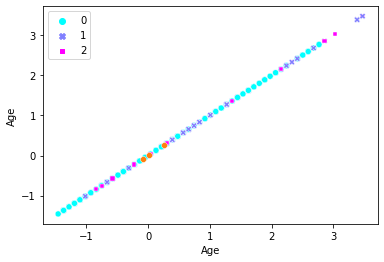

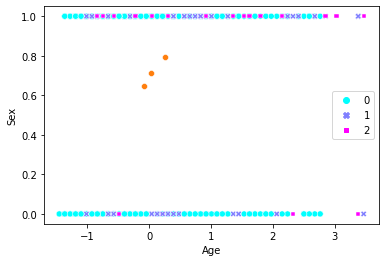

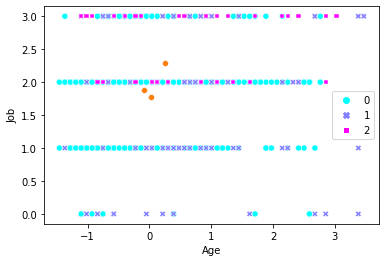

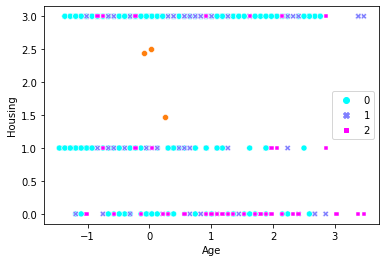

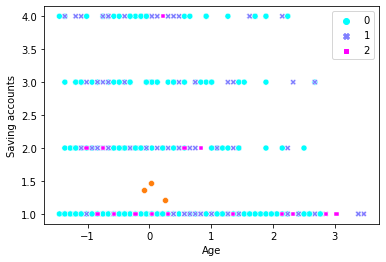

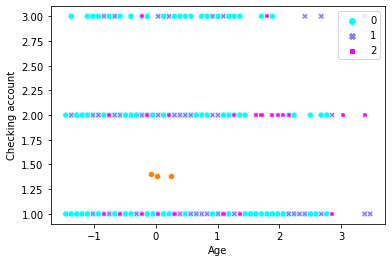

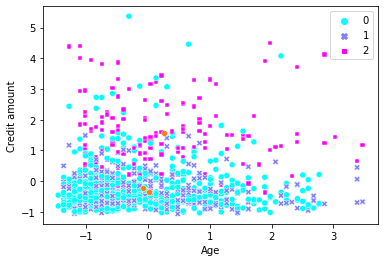

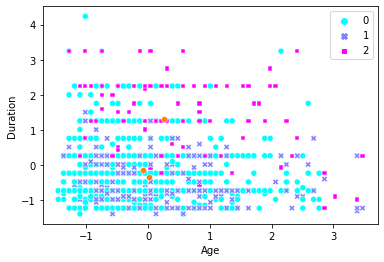

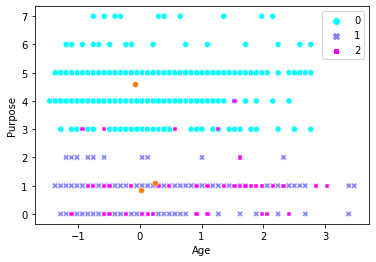

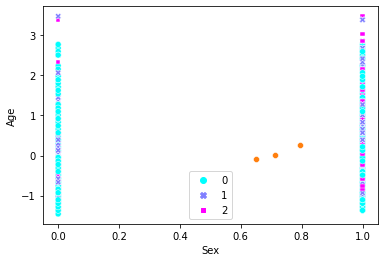

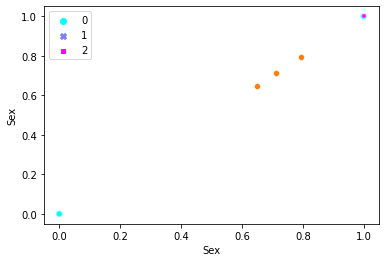

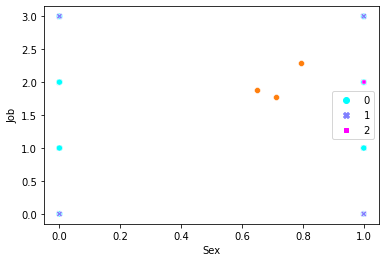

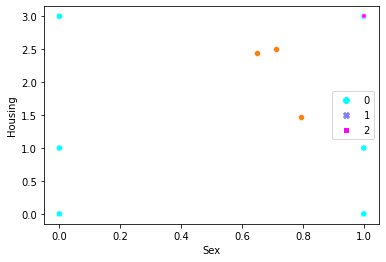

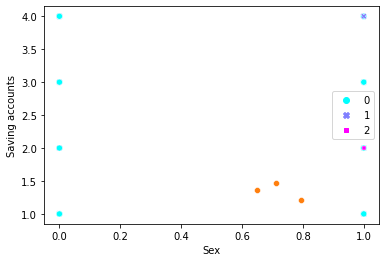

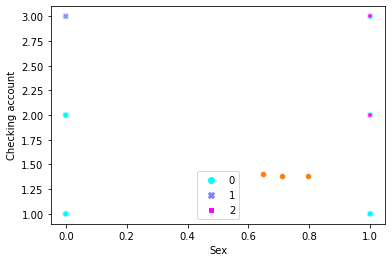

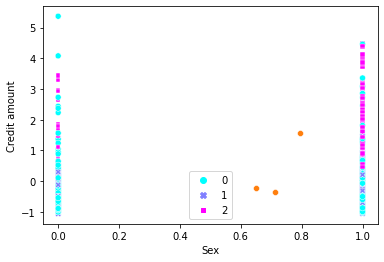

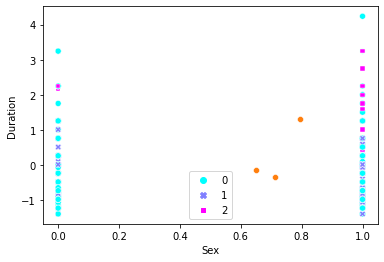

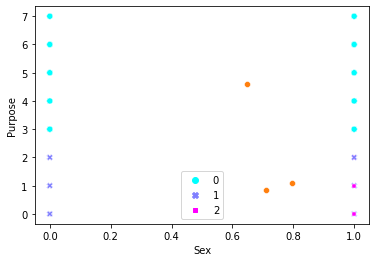

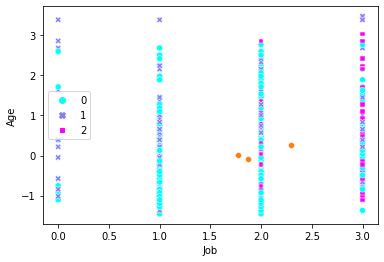

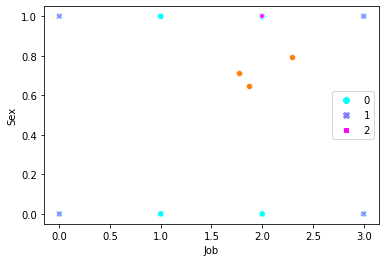

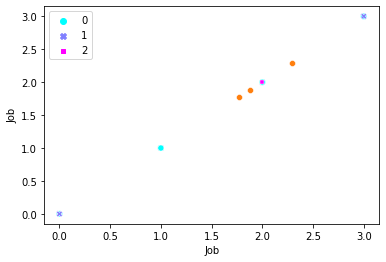

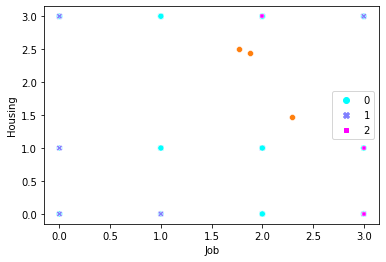

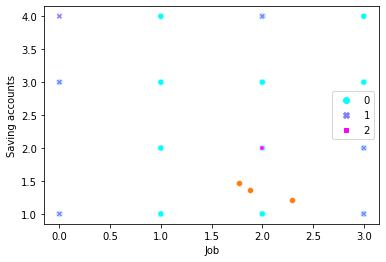

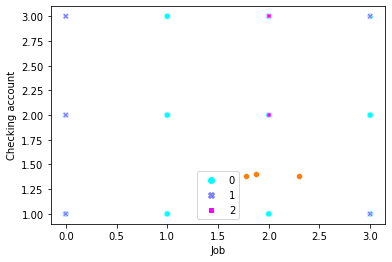

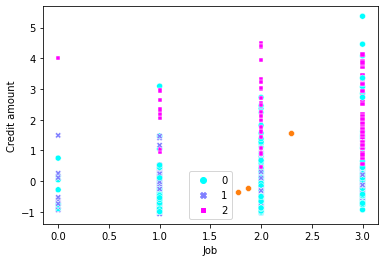

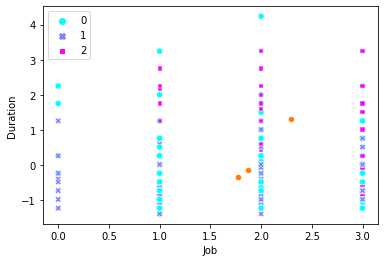

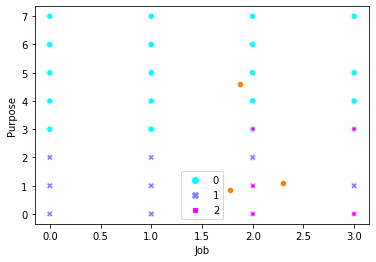

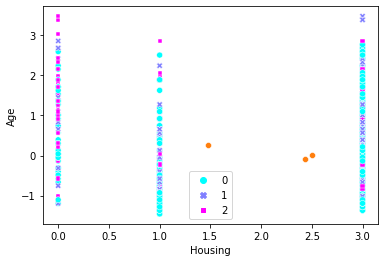

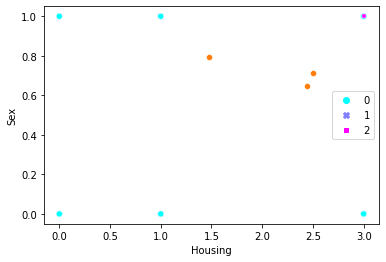

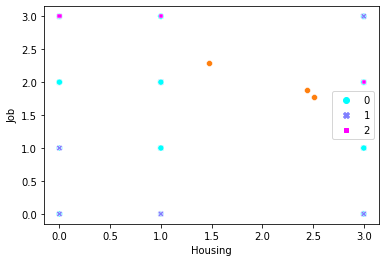

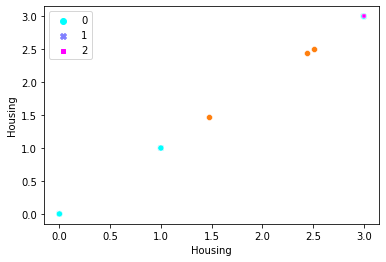

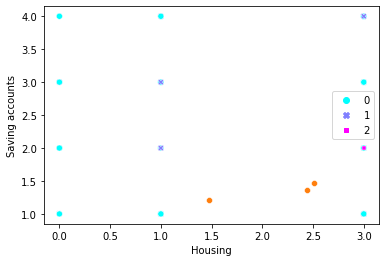

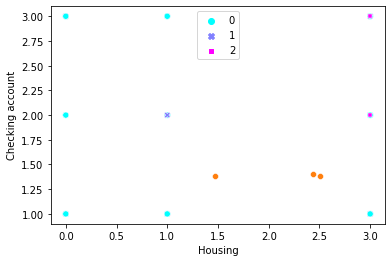

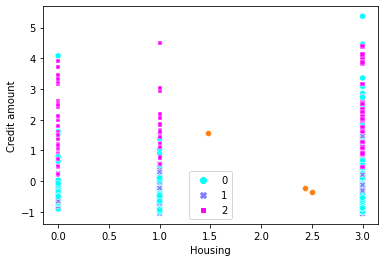

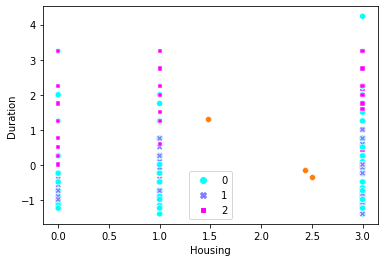

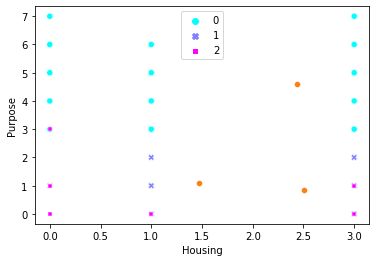

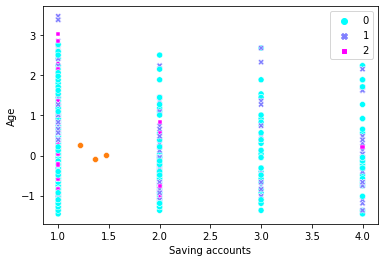

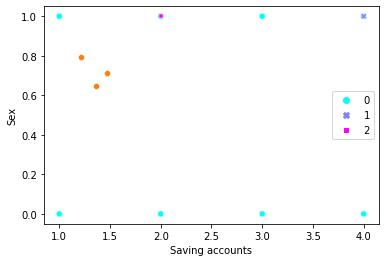

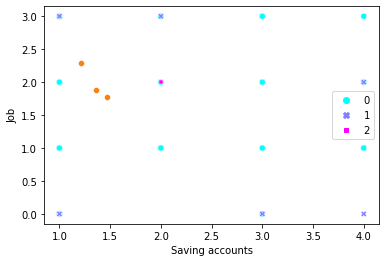

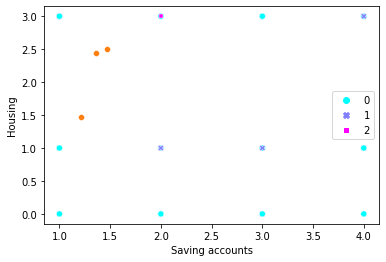

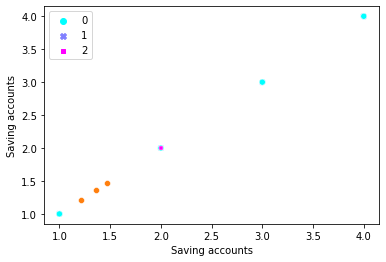

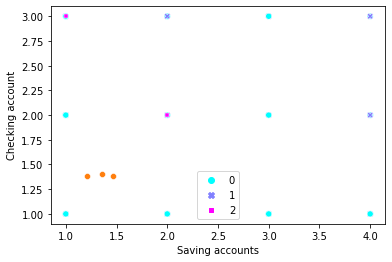

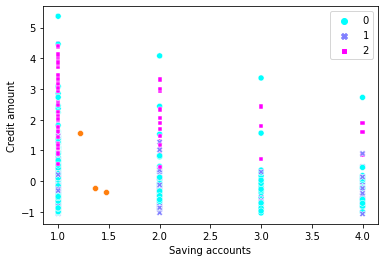

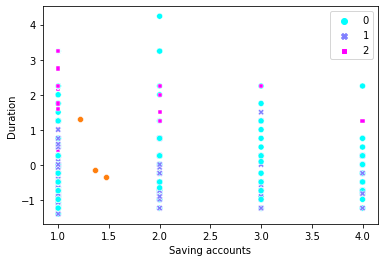

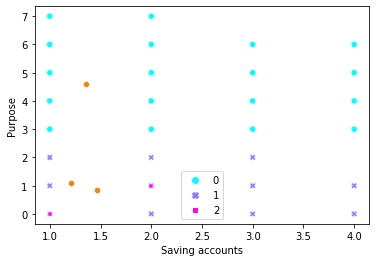

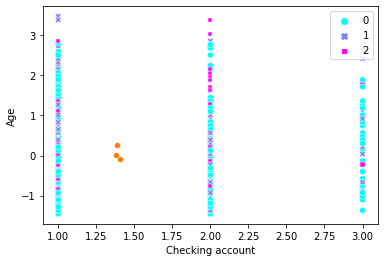

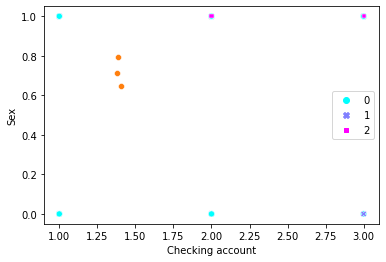

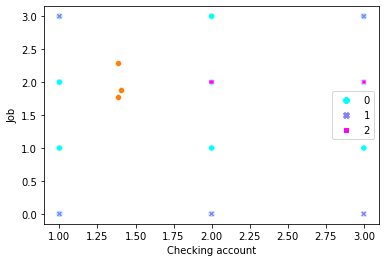

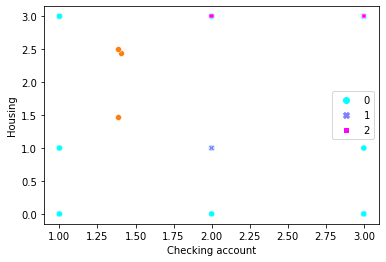

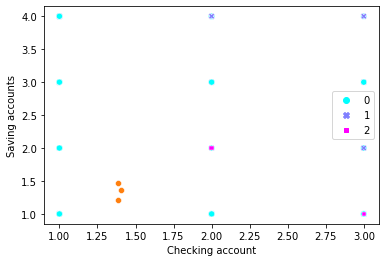

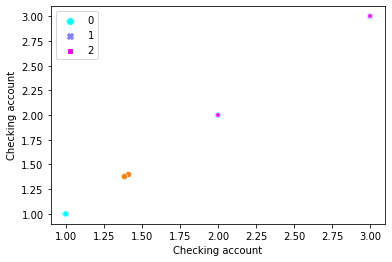

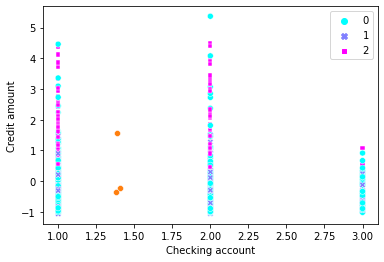

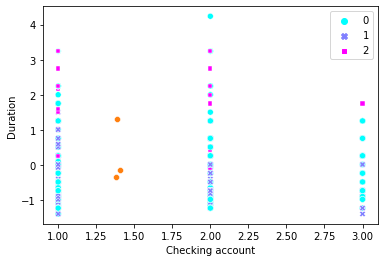

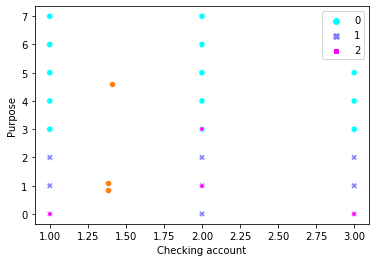

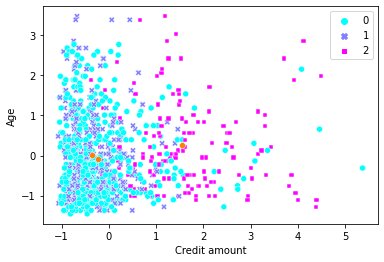

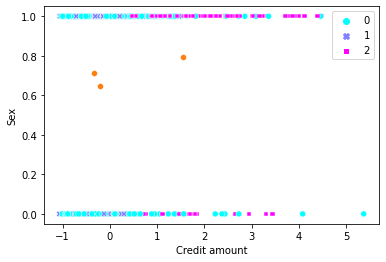

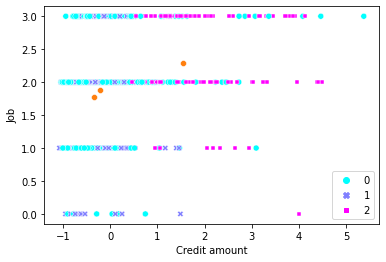

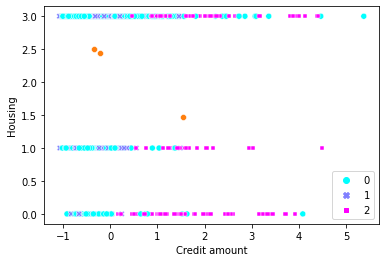

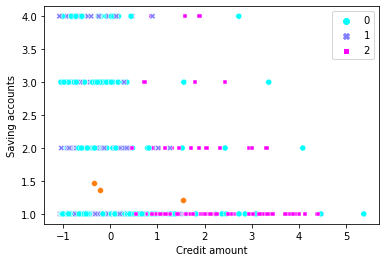

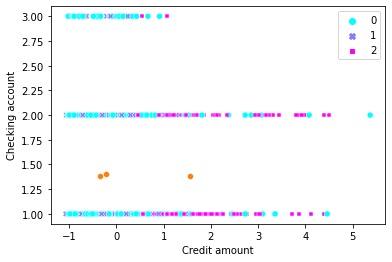

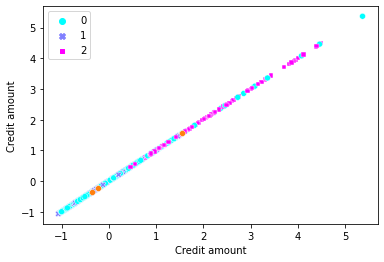

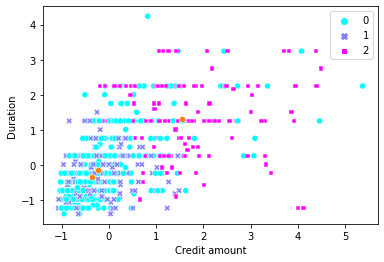

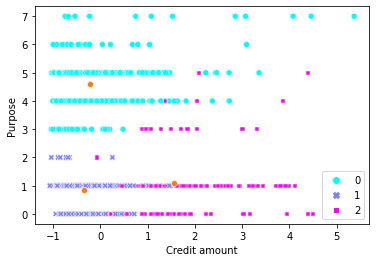

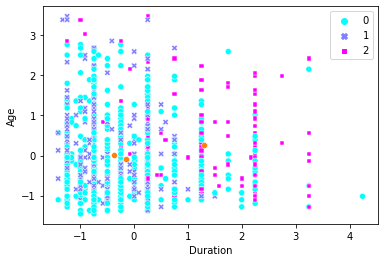

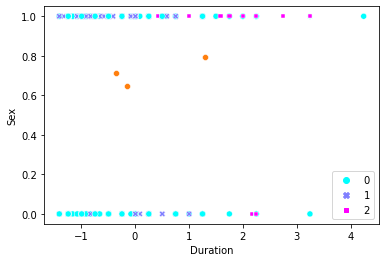

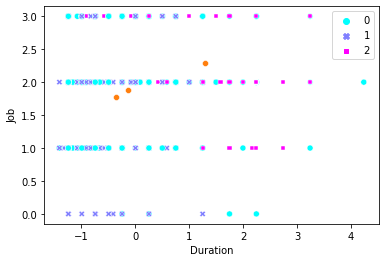

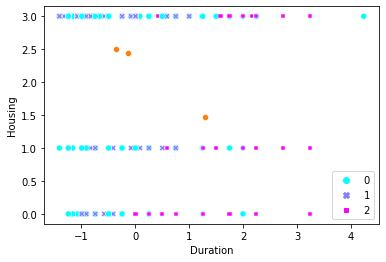

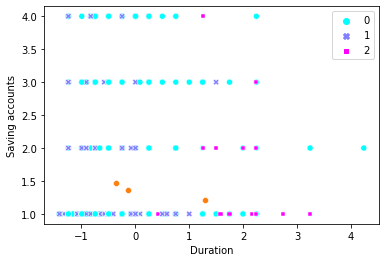

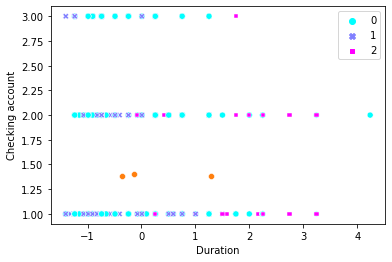

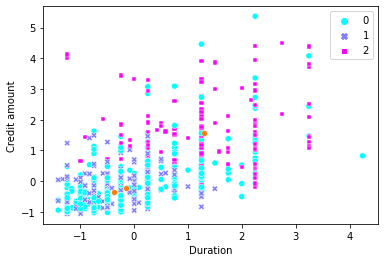

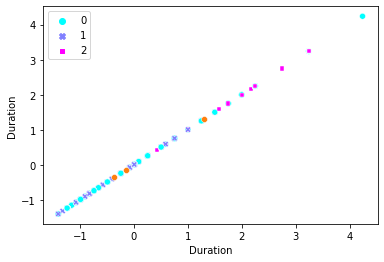

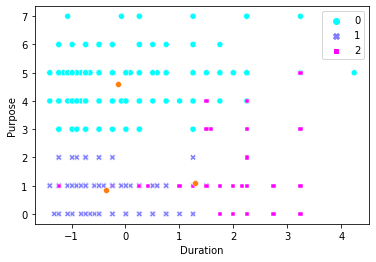

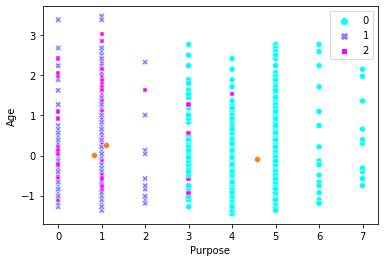

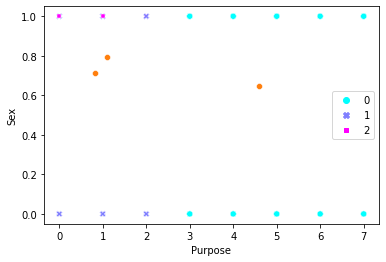

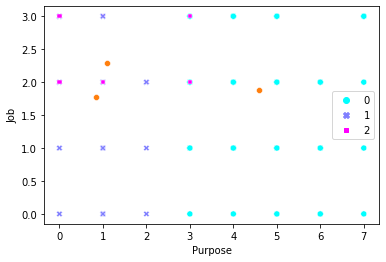

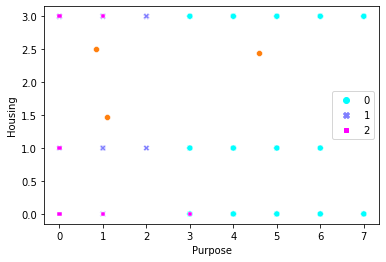

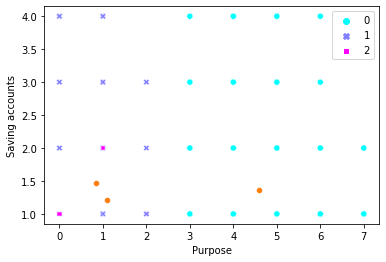

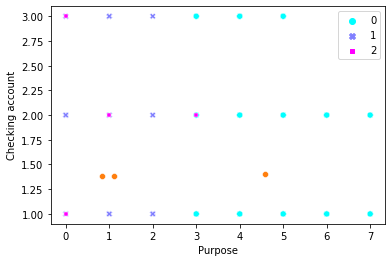

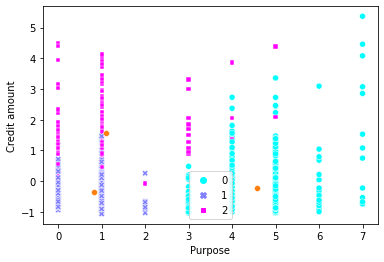

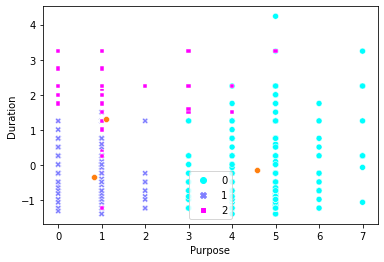

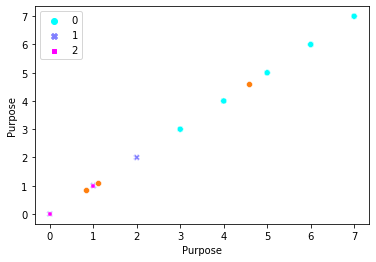

In [346]:
kmeans_sca = KMeans(n_clusters=3).fit(data_scaler)

y_pred_sca = kmeans_sca.predict(data_scaler)
C_sca = kmeans_sca.cluster_centers_


plot_cluster(data_scaler,y_pred_sca,C_sca)

**les visuelles sont moins propres que la méthode précedente (surtout crédit vs age )**

In [347]:
tab(data_scaler,y_pred_sca)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


cluster       Age           Credit amount            Duration          
               mean    median          mean    median      mean    median
0       0 -0.019993 -0.223927     -0.489549 -0.540972 -0.347189 -0.489762
1       1  0.044642 -0.091998      2.985948  2.807100  1.556297  1.252574
2       2  0.055811 -0.135974      0.875825  0.870244  0.766671  0.547342

,,Sex,Job,Housing,Saving accounts,Checking account,Purpose
cluster,,,,,,,
0,0,1,2,3,1,1,5
1,0,1,3,3,1,1,1
2,0,1,2,3,1,1,1


# KMeans avec dummies

In [348]:
def OneHotEncod(df,cols):
    for col in cols:
        dummy=pd.get_dummies(df[col],prefix=col) # dataFrame of dummies for each modality of the variable
        df=df.drop(col,axis=1) #drop the former variable
        df=pd.concat([df,dummy],axis=1) #put the dummies in the dataFrame
    print("columns of the output:" ,df.columns)
    return df

categorical = ['Sex','Job','Housing','Saving accounts','Checking account','Purpose']
data_dum = OneHotEncod(data,categorical)

columns of the output: Index(['Age', 'Credit amount', 'Duration', 'Sex_0', 'Sex_1', 'Job_0', 'Job_1',
       'Job_2', 'Job_3', 'Housing_0', 'Housing_1', 'Housing_3',
       'Saving accounts_1', 'Saving accounts_2', 'Saving accounts_3',
       'Saving accounts_4', 'Checking account_1', 'Checking account_2',
       'Checking account_3', 'Purpose_0', 'Purpose_1', 'Purpose_2',
       'Purpose_3', 'Purpose_4', 'Purpose_5', 'Purpose_6', 'Purpose_7'],
      dtype='object')


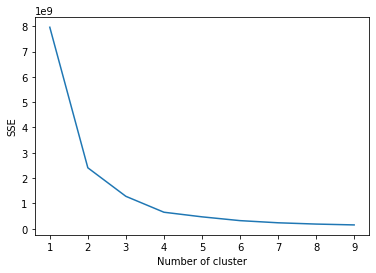

In [349]:
nb_cluster(data_dum)

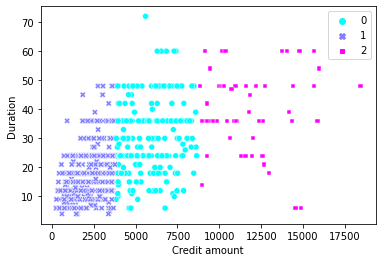

In [350]:
kmeans_dum = KMeans(n_clusters=3).fit(data_dum)
y_pred_dum = kmeans_dum.predict(data_dum)
C_dum = kmeans_dum.cluster_centers_

sns.scatterplot(x=data_dum.iloc[:, 1], y=data_dum.iloc[:, 2], hue=y_pred_dum, palette='cool', style=y_pred_dum) 
#plot_cluster(data_dum,y_pred_dum,C_dum)

In [351]:
df_y_pred_dum = pd.DataFrame(data=y_pred_dum, columns=['cluster'])
tab1 = pd.concat([data_dum, df_y_pred_dum], axis=1)
display(tab1.groupby(['cluster']).agg(['mean', 'median']).reset_index())

cluster        Age        Credit amount  ... Purpose_6        Purpose_7       
                mean median          mean  ...      mean median      mean median
0       0  36.180556   34.0   5742.245370  ...  0.018519      0  0.013889      0
1       1  35.318681   33.0   1890.082418  ...  0.023352      0  0.005495      0
2       2  36.053571   34.5  11695.589286  ...  0.017857      0  0.089286      0

[3 rows x 55 columns]

# PCA et MCA avec KMeans

In [352]:
!pip install prince

In [353]:
import prince

numerical = ['Credit amount','Age','Duration']
data_pca = data[numerical]
data_mca = data[categorical]
data_mca = OneHotEncod(data_mca, categorical)


columns of the output: Index(['Sex_0', 'Sex_1', 'Job_0', 'Job_1', 'Job_2', 'Job_3', 'Housing_0',
       'Housing_1', 'Housing_3', 'Saving accounts_1', 'Saving accounts_2',
       'Saving accounts_3', 'Saving accounts_4', 'Checking account_1',
       'Checking account_2', 'Checking account_3', 'Purpose_0', 'Purpose_1',
       'Purpose_2', 'Purpose_3', 'Purpose_4', 'Purpose_5', 'Purpose_6',
       'Purpose_7'],
      dtype='object')


In [354]:
data_mca.head()

,Sex_0,Sex_1,Job_0,Job_1,Job_2,Job_3,Housing_0,Housing_1,Housing_3,Saving accounts_1,Saving accounts_2,Saving accounts_3,Saving accounts_4,Checking account_1,Checking account_2,Checking account_3,Purpose_0,Purpose_1,Purpose_2,Purpose_3,Purpose_4,Purpose_5,Purpose_6,Purpose_7
0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [355]:
pca = prince.PCA(n_components=2, random_state=0).fit(data_pca)
df_pca = pd.DataFrame(pca.transform(data_pca))
df_pca.columns = ["Composant1_pca", "Composante2_pca"]

print ("Explained Inertia")
print (list(pca.explained_inertia_))

print ("Total Inertia")
print (pca.total_inertia_)

print ("Column correlations")
print (pca.column_correlations(data_pca))

Explained Inertia
[0.5416645279201519, 0.33458685446532227]
Total Inertia
3.0
Column correlations
                      0         1
Age           -0.004947  0.998881
Credit amount  0.901243  0.057442
Duration       0.901515 -0.051943


l'inertie des deux premiéres composantes est prés de 90%

In [356]:
mca = prince.MCA(n_components=2, random_state=0).fit(data_mca)
df_mca = pd.DataFrame(mca.transform(data_mca))
df_mca.columns = ["Composant1_mca", "Composante2_mca"]

#print("l'inertie total est :" ,mca.total_inertia_)
#print("les inertie expliqué sont :",mca.explained_inertia_)

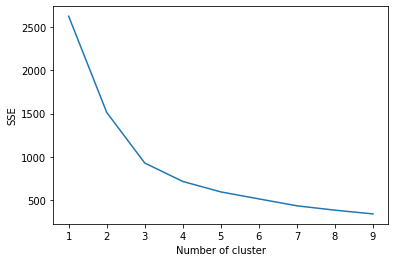

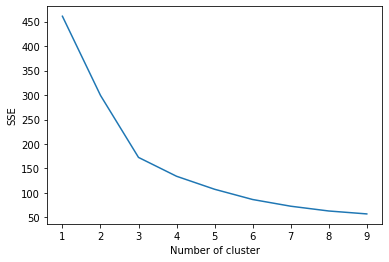

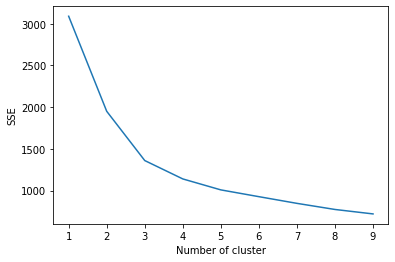

In [357]:
nb_cluster(df_pca)
nb_cluster(df_mca)


df_mca.head()

df_ca = pd.concat([df_pca,df_mca],axis=1)
nb_cluster(df_ca)

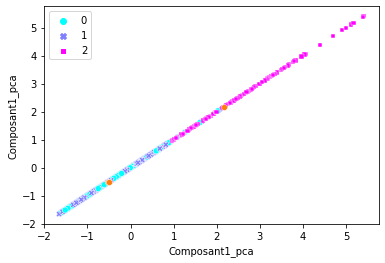

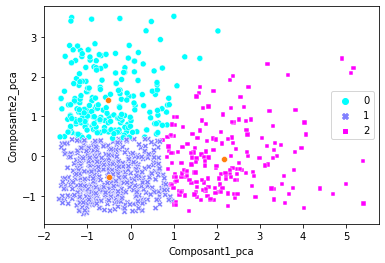

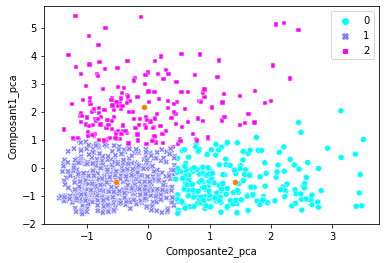

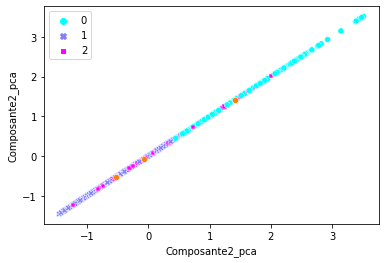

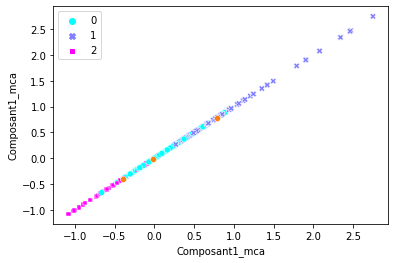

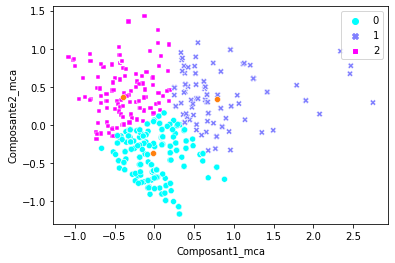

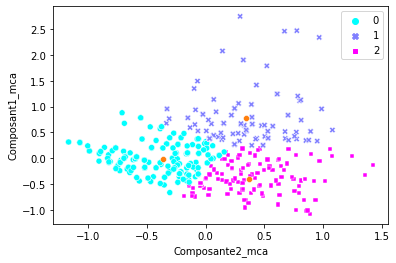

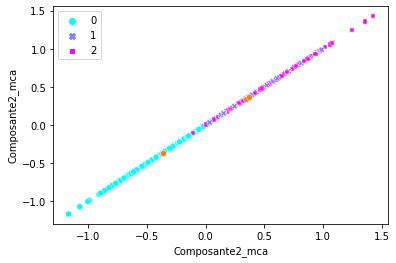

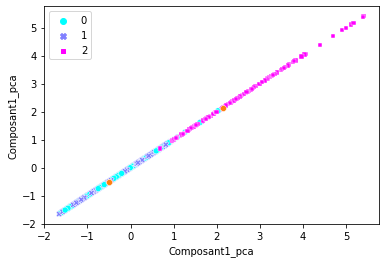

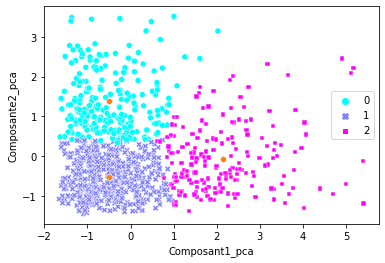

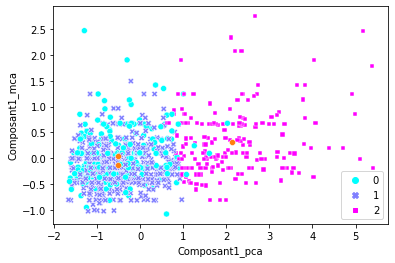

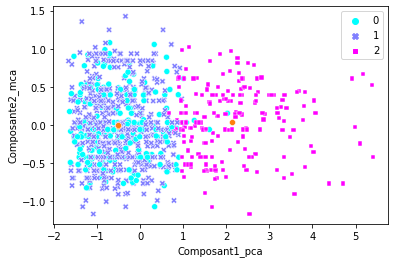

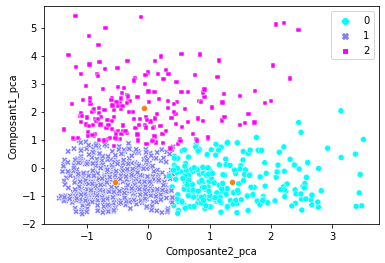

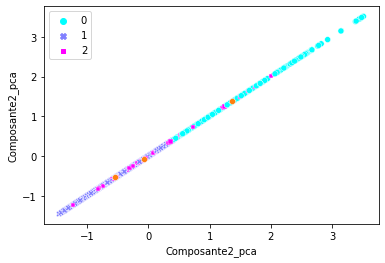

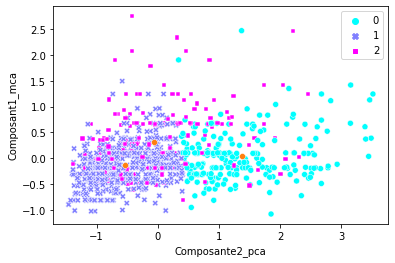

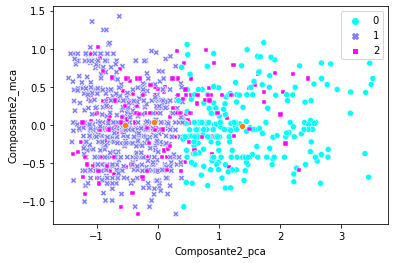

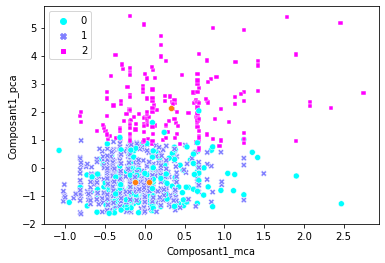

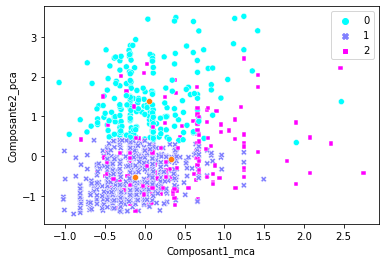

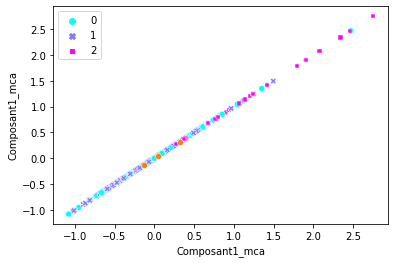

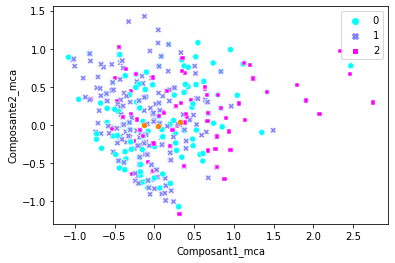

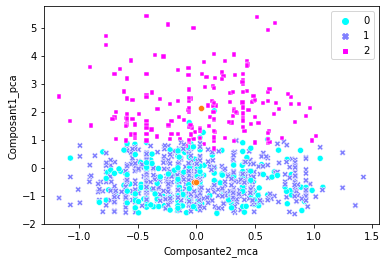

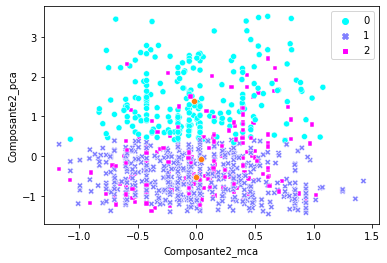

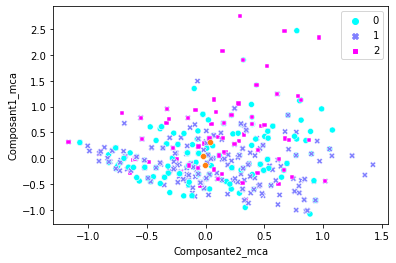

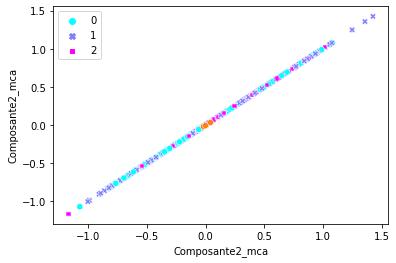

In [358]:
kmeans_pca = KMeans(n_clusters=3).fit(df_pca)
y_pred_pca = kmeans_pca.predict(df_pca)
C_pca = kmeans_pca.cluster_centers_

kmeans_mca = KMeans(n_clusters=3).fit(df_mca)
y_pred_mca = kmeans_mca.predict(df_mca)
C_mca = kmeans_mca.cluster_centers_

kmeans_ca = KMeans(n_clusters=3).fit(df_ca)
y_pred_ca = kmeans_ca.predict(df_ca)
C_ca = kmeans_ca.cluster_centers_




plot_cluster(df_pca,y_pred_pca,C_pca)
plot_cluster(df_mca,y_pred_mca,C_mca)
plot_cluster(df_ca,y_pred_ca,C_ca)


# FAMD plus KMeans

In [359]:
data_init.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [360]:
df = imputeNA(data_init)

famd = prince.FAMD(n_components=2, random_state=0)
famd = famd.fit(df)
df_famd = pd.DataFrame(famd.transform(df))
df_famd.columns = ["Composante1","Composante2"]



In [361]:
print("l'inertie total est :" ,famd.total_inertia_)
print("les inertie expliqué sont :",famd.explained_inertia_)

l'inertie total est : 0.008792588649597437
les inertie expliqué sont : [0.12736507 0.08614004]


l'inertie expliqué est trés mauvaise

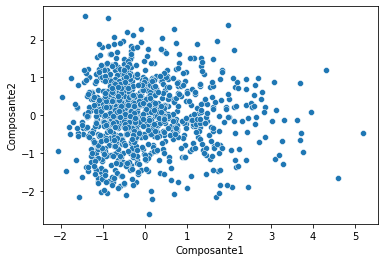

In [362]:
sns.scatterplot(x="Composante1",y="Composante2",data=df_famd)

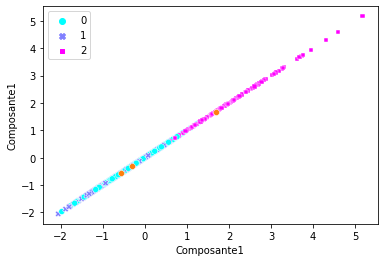

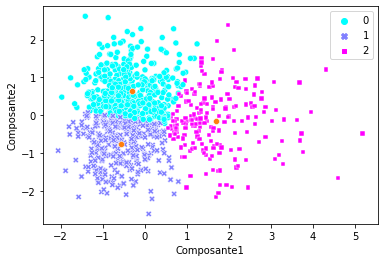

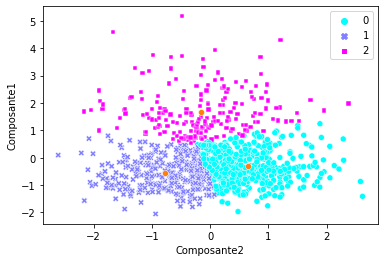

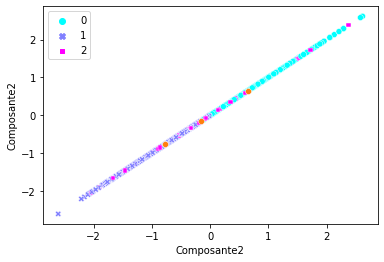

In [363]:
kmeans_famd = KMeans(n_clusters=3).fit(df_famd)
y_pred_famd = kmeans_famd.predict(df_famd)
C_famd = kmeans_famd.cluster_centers_

plot_cluster(df_famd,y_pred_famd,C_famd)